In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

#df['phase'] = df['phase'].replace({'M': 'G2'})

# Separate features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])  # exclude phase and age
y = df['age']  # target is now age

In [4]:
## hypertuning

# Split data into train and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

# Train Random Forest Regressor with 500 trees and max depth 15
rf = RandomForestRegressor(n_estimators=500, max_depth=50, max_features='sqrt', random_state=949)

param_grid = {
    'n_estimators': [600, 700]              
    #'max_depth': [40, 50, 60]          
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring= 'neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)

Best parameters: {'n_estimators': 600}


In [5]:
#retrain 
rf = RandomForestRegressor(n_estimators=600, max_depth=50, max_features='sqrt', random_state=949)
rf.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [6]:
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

# Calculate R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")
print(f"R^2: {r2_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")
print(f"R^2: {r2_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)

=== Training Set ===
RMSE: 0.6125
R^2: 0.9861

=== Test Set ===
RMSE: 1.6970
R^2: 0.8925
RMSE per phase (Train):
phase
G0    0.688052
G1    0.503004
G2    0.660770
M     2.897589
S     0.527113
dtype: float64

RMSE per phase (Test):
phase
G0    1.857665
G1    1.394204
G2    1.901888
M     7.855489
S     1.498021
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_26363/1979247717.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_26363/1979247717.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(


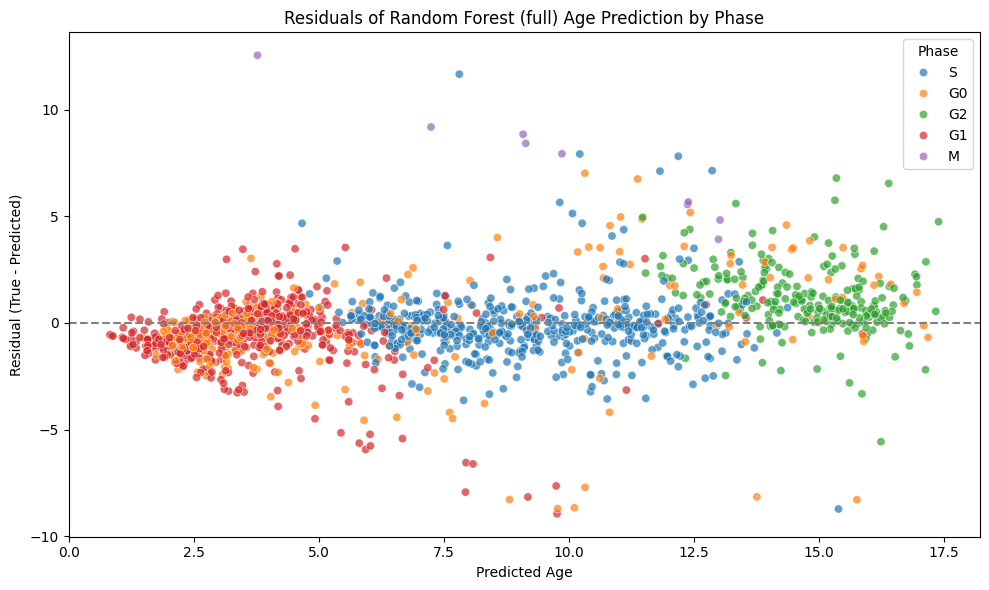

In [7]:
## PLOT RESIDUALS
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'True Age': y_test,
    'Predicted Age': y_test_pred,
    'Residual': y_test - y_test_pred,
    'Phase': df.loc[y_test.index, 'phase']
})

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Predicted Age',
    y='Residual',
    hue='Phase',
    palette='tab10',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of Random Forest (full) Age Prediction by Phase")
plt.xlabel("Predicted Age")
plt.ylabel("Residual (True - Predicted)")
plt.legend(title='Phase')
plt.tight_layout()

# Save the plot
plot_path = "rf_regression_full.png"
plt.savefig(plot_path, dpi=300)
plt.show()